In [1]:
!pip install rasterio

In [1]:
import zipfile

import matplotlib.pyplot as plt
import pandas as pd

from hda import Client

import rasterio
from rasterio.windows import Window
from rasterio.plot import show
from rasterio.enums import Resampling

%run helpers.ipynb

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# 1. Downloading data

In [3]:
data = {
    "datasetId": "EO:CLMS:DAT:CORINE",
    "stringChoiceValues": [
        {
            "name": "product_type",
            "value": "Corine Land Cover 2018"
        },
        {
            "name": "format",
            "value": "GeoTiff100mt"
        }
    ]
}

In [4]:
c = Client(debug=False)

matches = c.search(data)
matches.download()

Exception: Missing/incomplete configuration file: /home/jovyan/.hdarc

In [ ]:
zip_ref = zipfile.ZipFile("u2018_clc2018_v2020_20u1_raster100m.zip")
zip_ref.extractall("./data")
zip_ref.close() # close file

# 2. Data Understanding

## 2.1 Work with Rasterio

In [40]:
tif_path = 'data/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif'   # set path
dataset = rasterio.open(tif_path)

In [41]:
# show data information
print("Count:",dataset.count)
print()
print("CRS:", dataset.crs)
print()
print("Width:", dataset.width, "Height", dataset.height)

dataset.meta
dataset.descriptions
dataset.name
data.size
data.dtype
data.min()
data.max()

Count: 1

CRS: PROJCS["ETRS_1989_LAEA",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]

Width: 65000 Height 46000


48

In [42]:
data = dataset.read()
data

array([[[-128, -128, -128, ..., -128, -128, -128],
        [-128, -128, -128, ..., -128, -128, -128],
        [-128, -128, -128, ..., -128, -128, -128],
        ...,
        [-128, -128, -128, ..., -128, -128, -128],
        [-128, -128, -128, ..., -128, -128, -128],
        [-128, -128, -128, ..., -128, -128, -128]]], dtype=int8)

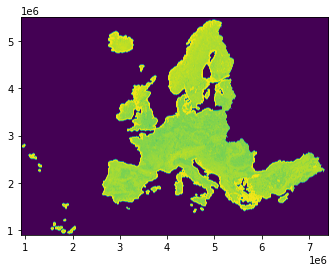

<AxesSubplot:>

In [43]:
# show complete data
show(dataset)

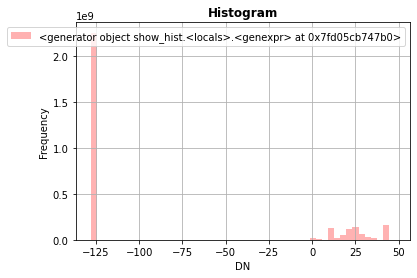

In [44]:
# histogram
from rasterio.plot import show_hist

show_hist(dataset, bins=50, lw=0.0, stacked=False, alpha=0.3,
      histtype='stepfilled', title="Histogram")

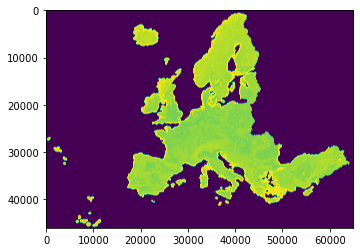

In [45]:
# plot data with matplotlib
plt.imshow(dataset.read(1))
plt.show()

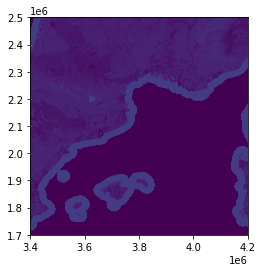

<AxesSubplot:>

In [46]:
# show specific region data


# X coordinate, Y coordinate, Width, height
window = Window(25000, 30000, 8000, 8000)

data_cropped = dataset.read(window=window, masked=True)
show(data_cropped, transform=dataset.window_transform(window), vmin=0, vmax=255)

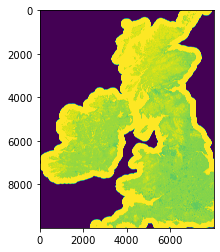

In [47]:
#render same graph using pyplot
window = Window(20000, 14000, 8000, 10000)
data_cropped = dataset.read(window=window, masked=True)
plt.imshow(data_cropped.squeeze())
plt.show()

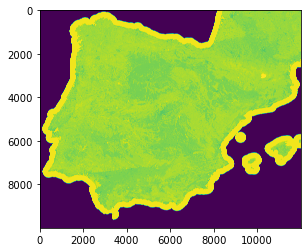

<AxesSubplot:>

In [48]:
# show Spain
# X coordinate, Y coordinate, Width, height
window = Window(17000, 30000, 12000, 10000)

data_cropped = dataset.read(window=window, masked=True)
show(data_cropped)

# 2.2 Work with data

In [49]:
legend = pd.read_csv("data/u2018_clc2018_v2020_20u1_geoPackage/Legend/CLC_legend.csv", delimiter = ";")
legend["RGB"] = legend["RGB"].fillna("000-000-000")
legend["RGB"] = legend["RGB"].apply(lambda c : '#%02x%02x%02x'%tuple(int(x) for x in c.split("-"))) # convert RGB to hex
code_color = pd.Series(legend.RGB.values,index=legend.CLC_CODE).to_dict()
code_gridcode = pd.Series(legend.GRID_CODE.values,index=legend.CLC_CODE).to_dict()
gridcode_color = pd.Series(legend.RGB.values,index=legend.GRID_CODE).to_dict()


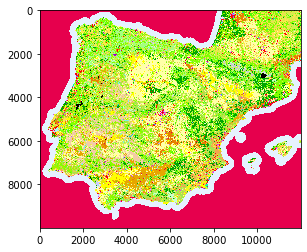

In [50]:
import matplotlib as mpl
from matplotlib import pyplot
import numpy as np



# make a color map of fixed colors
cmap = mpl.colors.ListedColormap(gridcode_color.values())
bounds=np.array(list(gridcode_color.keys())) 
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# tell imshow about color map so that only set colors are used
img = pyplot.imshow(data_cropped.squeeze(),interpolation='nearest',
                    cmap = cmap,norm=norm )


pyplot.show()

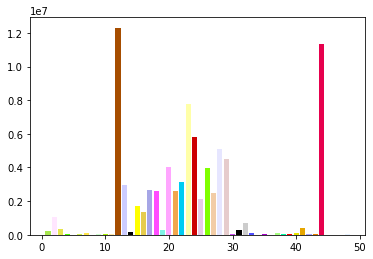

In [51]:
from collections import Counter
d = Counter(data_cropped.flatten().tolist())
d.pop(-128)



plt.bar(d.keys(), d.values(),color=gridcode_color.values())

plt.show()

# 3. Data preparation